<a href="https://colab.research.google.com/github/Zain506/Similarity/blob/main/notebooks/MedCLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpret and deploy MedCLIP pipeline

In [14]:
import os
from dotenv import load_dotenv
try:
    from google.colab import userdata
    tok = userdata.get('HF_TOKEN')
except:
    load_dotenv()
    tok = os.getenv("HF_TOKEN")
os.environ["HF_TOKEN"] = tok

In [15]:
from transformers import AutoTokenizer, AutoModel
import torch
tokeniser = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT") # Generate input tokens
texts = [
    "Patient has a cold",
    "Patient has a sore throat and no other symptoms",
    "Patient is vomiting blood and has a collapsed lung"
    ]

In [16]:
inputs = tokeniser(texts, padding=True, truncation=True, return_tensors="pt") # Tokens
print(inputs)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': tensor([[  101,  5351,  1144,   170,  2504,   102,     0,     0,     0,     0,
             0,     0],
        [  101,  5351,  1144,   170, 15939,  2922,  1105,  1185,  1168,  8006,
           102,     0],
        [  101,  5351,  1110, 26979,  1158,  1892,  1105,  1144,   170,  7322,
         13093,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [17]:
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT") # Load Neural Network
with torch.no_grad(): # Apply forward pass without calculating gradients to speed up computation
    outputs = model(**inputs) # Apply Attention Mechanism to each token to generate embeddings

hidden_states = outputs.last_hidden_state # "Hidden_states" is the attention-mechanism output
print(hidden_states.shape)

torch.Size([3, 12, 768])


In [18]:
# Apply Pooling with a mask (similar to filtering Pandas DataFrame)
mask = inputs["attention_mask"].unsqueeze(-1)
pooled = (hidden_states * mask).sum(dim=1) / mask.sum(dim=1)
print(pooled)

tensor([[ 0.5553,  0.0857, -0.4640,  ...,  0.0184,  0.0646, -0.1259],
        [ 0.1498,  0.1194, -0.3643,  ...,  0.2049,  0.1319, -0.3943],
        [ 0.1813,  0.0279, -0.3916,  ...,  0.2560,  0.1692, -0.3637]])


# Full Text Encoder class loading

In [19]:
from transformers import AutoTokenizer, AutoModel
import torch

class Model:
    """Import model with AutoTokenizer and Automodel. Defaults to BioClinicalBERT"""
    def __init__(self, link="emilyalsentzer/Bio_ClinicalBERT"):
        self.tokenizer = AutoTokenizer.from_pretrained(link)
        self.model = AutoModel.from_pretrained(link) # Load Neural Network
    def embeddings(self, texts):
        inputs = self.tokenizer(texts, padding=True, truncation=True, return_tensors="pt") # Tokens

        with torch.no_grad(): # Apply forward pass without calculating gradients to speed up computation
            outputs = self.model(**inputs) # Apply Attention Mechanism to each token to generate embeddings

        hidden_states = outputs.last_hidden_state # "Hidden_states" is the attention-mechanism output
        # Apply Pooling with a mask (similar to filtering Pandas DataFrame)
        mask = inputs["attention_mask"].unsqueeze(-1)
        pooled = (hidden_states * mask).sum(dim=1) / mask.sum(dim=1)
        return pooled

In [20]:
tmp = Model().embeddings(["Patient has a cold", "Patient is vomiting blood", "Patient has a cold and is vomiting blood", "Patient has a cold"])
print(tmp)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


tensor([[ 0.5553,  0.0857, -0.4640,  ...,  0.0184,  0.0646, -0.1259],
        [ 0.2254,  0.1918, -0.5101,  ...,  0.2051,  0.2852, -0.2781],
        [ 0.2372,  0.1547, -0.4852,  ...,  0.2074,  0.1997, -0.2425],
        [ 0.5553,  0.0857, -0.4640,  ...,  0.0184,  0.0646, -0.1259]])


In [21]:
import torch
from torch.nn.functional import normalize as n
if torch.cuda.is_available():
  tmp.to("cuda")
  normed = n(tmp, p=2, dim=1)
  result = normed @ normed.t()
  print(result)
else:
  print("GPU not available")

tensor([[1.0000, 0.8570, 0.9171, 1.0000],
        [0.8570, 1.0000, 0.9516, 0.8570],
        [0.9171, 0.9516, 1.0000, 0.9171],
        [1.0000, 0.8570, 0.9171, 1.0000]])


## Image Encoder

In [28]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("microsoft/swinv2-tiny-patch4-window16-256")
model = AutoModelForImageClassification.from_pretrained("microsoft/swinv2-tiny-patch4-window16-256")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
from PIL import Image
import requests
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

In [24]:
logits = outputs.logits
# predicted_class_idx = logits.argmax(-1).item()
# print("Predicted class:", model.config.id2label[predicted_class_idx])
print(type(logits))

<class 'torch.Tensor'>


In [25]:
import torch
if torch.cuda.is_available():
  logits.to("cuda")
  print("GPU found")
  print(logits.shape)

else:
  print("GPU not found. Converting to NumPy")
  logits = logits.detach().cpu().numpy()
  print(logits.shape)

GPU found
torch.Size([1, 1000])


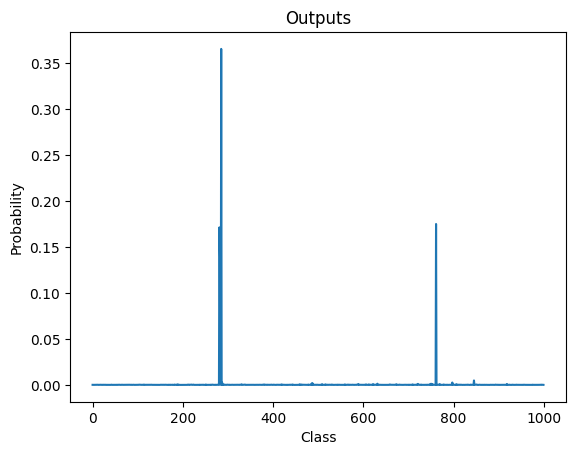

In [26]:
# Class to generate graph from tensors (display probability distribution of output logits)
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
def softmaxed(vector: torch.Tensor):
  return (torch.sum(vector) == 1).item() and (vector >= 0).all().item() and (vector <= 1).all().item()

def plotOutput(vector):
  """
  Enables visualisation for output of Neural Network
  """
  if not softmaxed(vector):
    vector = F.softmax(vector, dim=1) # Softmax function makes vector L1 normalised
  vec = vector.detach().cpu().numpy()
  plt.plot(vec[0])
  plt.title("Outputs")
  plt.xlabel("Class")
  plt.ylabel("Probability")
  plt.show()

plotOutput(logits)


## Load Data